In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
!pwd

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks'

# LOADING THE TRAINING SET

In [5]:
# load the data

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.image as mpimg

class SatelliteDataset(Dataset):
    def __init__(self, images_dir, ground_truth_dir, transform=None):
        self.images_dir = images_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = mpimg.imread(img_name)


        ground_truth_name = os.path.join(self.ground_truth_dir, self.images[idx])
        ground_truth = mpimg.imread(ground_truth_name)

        if self.transform:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)
        
        #crop images to 256x256
        # image = image[:, 0:256, 0:256]
        # ground_truth = ground_truth[:, 0:256, 0:256]
        return image, ground_truth

    


torch.Size([3, 400, 400])


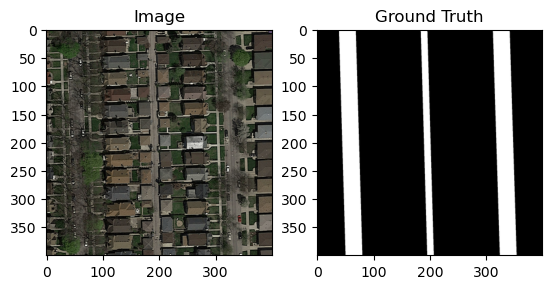

In [6]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Images to tensors
    # Add any other transforms you need here
])
dataset = SatelliteDataset("dataset/training/images", "dataset/training/groundtruth", transform=transform)

plt.subplot(1, 2, 1)

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(dataset[0][1].squeeze(), cmap='gray')

plt.title('Ground Truth')
#SHAPE IMAGE 
print(dataset[0][0].shape)
plt.show()



# defining the model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Risidual Dilated Convolution block
class ResidualDilatedBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.rdb = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, dilation=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )
        self.convID = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride= 2, padding=0)
    def forward(self, x):
        return self.rdb(x)+ self.convID(x)
    
#Risidual block
class RisidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.rdb = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2)
        )
        self.convID = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        return self.rdb(x)+ self.convID(x)
    
#Double Convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.convID = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        return self.double_conv(x)+self.convID(x)
    
# Upsampling block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()

        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2), #32x32 -> 64x64
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )
    def forward(self, x, input):
        x = self.upconv(x)
        x = torch.cat([x, input], dim=1)
        return x

class PPM(nn.Module):
    """
        Pyramid Pooling Module (PPM) class
    """
    def __init__(self, num_class, fc_dim, pool_scales=(1, 2, 3, 6)):
        super(PPM, self).__init__()

        self.ppm = []
        for scale in pool_scales:
            self.ppm.append(nn.Sequential(nn.AdaptiveAvgPool2d(scale),
                                          nn.Conv2d(fc_dim, 512, kernel_size=1, bias=False),
                                          nn.BatchNorm2d(512),
                                          nn.ReLU(inplace=True)))
            
        self.ppm = nn.ModuleList(self.ppm)
        
        self.conv_last = nn.Sequential(
            nn.Conv2d(fc_dim + len(pool_scales)*512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(512, num_class, kernel_size=1)
        )
    
    def forward(self, x, seg_size=None):
        """
            Forward pass of the PPM architecture
        """
        input_size = x.size()
        ppm_out = [x]
        
        for pool_scale in self.ppm:
            ppm_out.append(nn.functional.interpolate(pool_scale(x),
                                                     (input_size[2], input_size[3]),
                                                     mode='bilinear',
                                                     align_corners=False))
        ppm_out = torch.cat(ppm_out, 1)

        x = self.conv_last(ppm_out)

        if seg_size:  # is True during inference
            x = nn.functional.interpolate(x, size=seg_size, mode='bilinear', align_corners=False)
            x = nn.functional.softmax(x, dim=1)
        else:        
            x = nn.functional.log_softmax(x, dim=1)

        return x

    

# GC-DCNN model
class GCDCNN(nn.Module):
    def __init__ (self, n_channels, n_classes):
        super(GCDCNN, self).__init__()

        # Encoder
        self.dc1 = DoubleConv(n_channels, 64)
        self.rdb1 = ResidualDilatedBlock(64, 128)
        self.rdb2 = ResidualDilatedBlock(128, 256)
        self.rdb3 = ResidualDilatedBlock(256, 512)

        # PPM
        self.ppm = PPM(1024, 512)

        # Decoder
        # self.up1 = UpConv(1024, 512)
        # self.rb1 = RisidualBlock(512, 256)
        # self.up2 = UpConv(256, 128)
        # self.rb2 = RisidualBlock(256, 128)
        # self.up3 = UpConv(128, 64)
        # self.rb3 = RisidualBlock(128, 64)
        self.up1 = UpConv(1024, 256)
        self.rb1 = RisidualBlock(512, 256)
        self.up2 = UpConv(256, 128)
        self.rb2 = RisidualBlock(256, 128)
        self.up3 = UpConv(128, 64)
        self.rb3 = RisidualBlock(128, 64)

        # Output
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        print(x.shape)
        x1 = self.dc1(x)
        x2 = self.rdb1(x1)
        x3 = self.rdb2(x2)
        x4 = self.rdb3(x3)
        print(x4.shape)
        x5 = self.ppm(x4)
        print(x5.shape)
        x = self.up1(x5, x3)
        x = self.rb1(x)
        x = self.up2(x, x2)
        x = self.rb2(x)
        x = self.up3(x, x1)
        x = self.rb3(x)
        print(x.shape)

        logits = self.outc(x)
        print(logits.shape)
        return logits
  

# defining the loss function

In [8]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
        pred: tensor with first dimension as batch
        target: tensor with first dimension as batch
        """
    smooth = 1.
    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

# Training the model

In [9]:
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import copy
import time


def train_model(model, optimizer, scheduler, num_epochs=10):
    best_loss = 1e10
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_samples = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                torch.autograd.set_detect_anomaly(True)
                outputs = model(inputs)
                loss = dice_loss(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)

        train_epoch_loss = train_loss / train_samples
        print("Training Loss: {:.4f}".format(train_epoch_loss))

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_samples = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = dice_loss(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_samples += inputs.size(0)

        val_epoch_loss = val_loss / val_samples
        print("Validation Loss: {:.4f}".format(val_epoch_loss))

        # Check if this is the best model so far
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print("New best model saved with loss: {:.4f}".format(best_loss))

        # Print time elapsed for this epoch
        time_elapsed = time.time() - since
        print('Epoch complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Splitting dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

model = GCDCNN(n_channels=3, n_classes=1 ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
# Train the model
trained_model = train_model(model, optimizer, scheduler, num_epochs=10)


Epoch 0/9
----------
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Size([4, 64, 400, 400])
torch.Size([4, 1, 400, 400])
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Size([4, 64, 400, 400])
torch.Size([4, 1, 400, 400])
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Size([4, 64, 400, 400])
torch.Size([4, 1, 400, 400])
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Size([4, 64, 400, 400])
torch.Size([4, 1, 400, 400])
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Size([4, 64, 400, 400])
torch.Size([4, 1, 400, 400])
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Size([4, 64, 400, 400])
torch.Size([4, 1, 400, 400])
torch.Size([4, 3, 400, 400])
torch.Size([4, 512, 50, 50])
torch.Size([4, 1024, 50, 50])
torch.Siz

# visualize the results

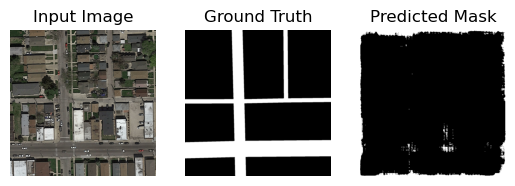

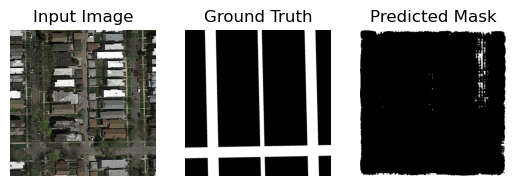

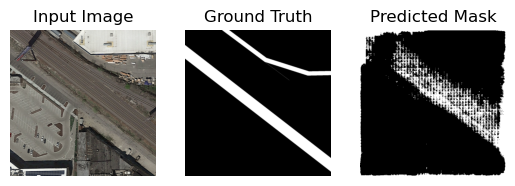

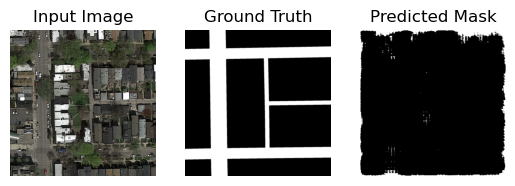

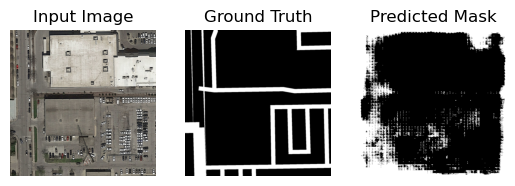

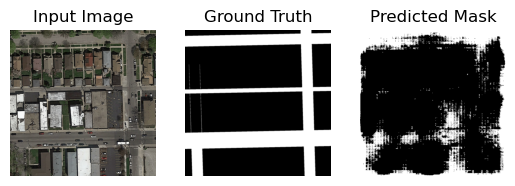

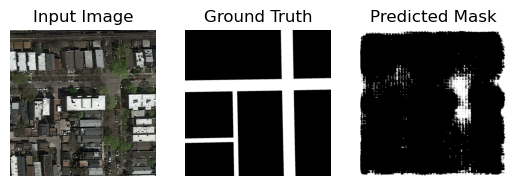

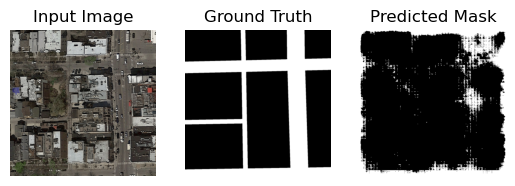

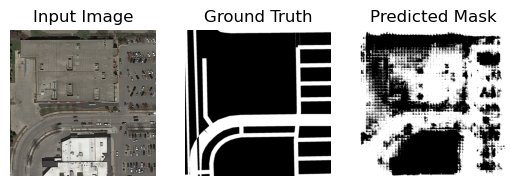

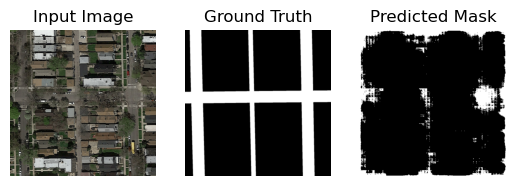

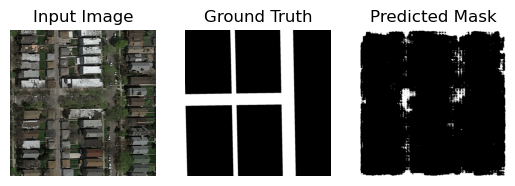

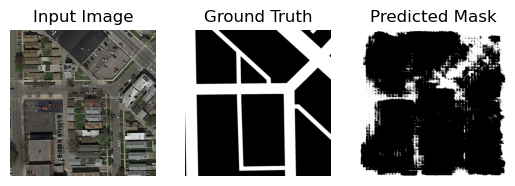

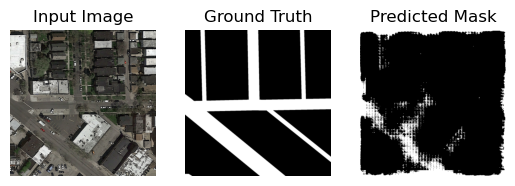

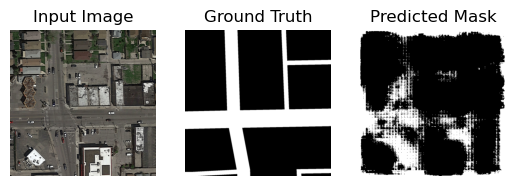

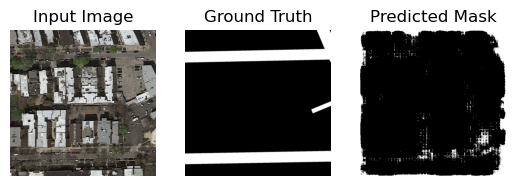

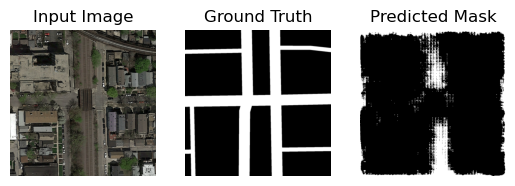

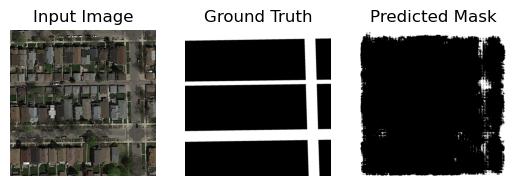

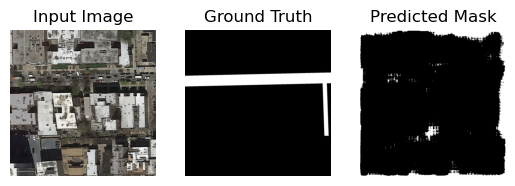

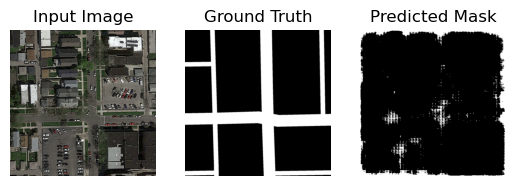

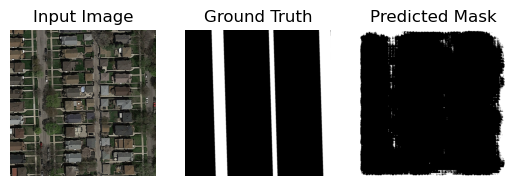

In [12]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
trained_model.eval()

# Iterate over the validation dataset
for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = trained_model(inputs)

    # Convert the predicted output to binary values
    predicted = torch.sigmoid(outputs) > 0.5
    #predicted = outputs

    # Convert tensors to numpy arrays
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Visualize the inputs, ground truth, and predicted masks
    for i in range(inputs.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i].transpose(1, 2, 0))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()
